# IMERG interpolate to 1.0 deg

In [1]:
import os
import sys
import yaml
import dask
import zarr
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob

import calendar
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
sys.path.insert(0, os.path.realpath('../libs/'))
import verif_utils as vu
import interp_utils as iu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
base_dir = '/glade/campaign/cisl/aiml/ksha/IMERG_V7/daily/'
output_dir = '/glade/campaign/cisl/aiml/ksha/IMERG_V7/daily/gather_yearly/'

In [5]:
imerg_name = output_dir + 'year_{}.zarr'

In [6]:
compress = zarr.Blosc(cname='zstd', clevel=1, shuffle=zarr.Blosc.SHUFFLE, blocksize=0)

chunk_size_3d = {
    'time': 1,
    'latitude': 181,
    'longitude': 360
}

dict_encoding = {}
dict_encoding['total_precipitation'] = {'compressor': compress, 'chunks': dict(chunks=(1, 181, 360))}

In [7]:
for year in range(2000, 2010):
    ds_01deg = xr.open_zarr(imerg_name.format(year))
    ds_01deg = ds_01deg.assign_coords(longitude=((ds_01deg.longitude + 360) % 360))
    ds_01deg = ds_01deg.sortby('longitude')
    ds_01deg = ds_01deg.transpose("time", "latitude", "longitude")
    
    # Define the target 1-degree grid
    lon_1deg = np.arange(0, 360, 1)
    lat_1deg = np.arange(-90, 91, 1)
    target_grid = iu.Grid.from_degrees(lon_1deg, lat_1deg)
    
    lon_01deg = ds_01deg['longitude'].values
    lat_01deg = ds_01deg['latitude'].values
    source_grid = iu.Grid.from_degrees(lon_01deg, lat_01deg)
    
    regridder = iu.ConservativeRegridder(source=source_grid, target=target_grid)
    
    ds_01deg = ds_01deg.chunk({'longitude': -1, 'latitude': -1})
    ds_merge_1deg = regridder.regrid_dataset(ds_01deg)
    
    # Reorder the dimensions for all variables in ds_merge_1deg
    for var in ds_merge_1deg.data_vars:
        # Get the current dimensions of the variable
        current_dims = ds_merge_1deg[var].dims
        
        # If both 'latitude' and 'longitude' are present, reorder them
        if 'latitude' in current_dims and 'longitude' in current_dims:
            # New order: move 'latitude' and 'longitude' to the first two positions, preserve other dimensions
            new_order = [dim for dim in current_dims if dim not in ['latitude', 'longitude']] + ['latitude', 'longitude']
            
            # Transpose the variable to the new order
            ds_merge_1deg[var] = ds_merge_1deg[var].transpose(*new_order)
    
    lon_1deg = np.arange(0, 360, 1)
    lat_1deg = np.arange(-90, 91, 1)
    
    # Add latitude and longitude as coordinates to ds_merge_1deg
    ds_merge_1deg = ds_merge_1deg.assign_coords({
        'latitude': lat_1deg,
        'longitude': lon_1deg
    })
    
    # flip latitude from -90 --> 90 to 90 --> -90
    ds_merge_1deg = ds_merge_1deg.isel(latitude=slice(None, None, -1))
    
    # float64 --> float32
    ds_merge_1deg = ds_merge_1deg.astype(
        {var: np.float32 for var in ds_merge_1deg if ds_merge_1deg[var].dtype == np.float64})

    ds_merge_1deg['precipitation'] = 0.001*ds_merge_1deg['precipitation']
    
    ds_merge_1deg['precipitation'] = ds_merge_1deg['precipitation'].fillna(0.0) # <----- NaN to zero
    
    ds_merge_1deg = ds_merge_1deg.rename({'precipitation': 'total_precipitation'})
    
    # chunk
    ds_merge_1deg = ds_merge_1deg.chunk(chunk_size_3d)
    
    # save
    save_name = output_dir + f'year_{year}_1deg_interp.zarr'
    # ds_merge_1deg.to_zarr(save_name, mode='w', consolidated=True, compute=True, encoding=dict_encoding)
    print('save to {}'.format(save_name))

### GPM vs. ERA5

In [8]:
ds_ERA5 = xr.open_zarr(
    '/glade/derecho/scratch/ksha/CREDIT_data/ERA5_plevel_1deg/upper_subset/ERA5_subset_1deg_6h_2020_conserve.zarr'
)

In [9]:
# 6 hourly to daily
variable_levels = {'total_precipitation': None,}
ds_ERA5 = vu.ds_subset_everything(ds_ERA5, variable_levels)
ds_ERA5_24h = vu.accum_6h_24h(ds_ERA5, 0)

# load to mem
ERA5_24h = ds_ERA5_24h['total_precipitation'].values

In [10]:
save_name = output_dir + 'year_2020_1deg_interp.zarr'
ds_gpm = xr.open_zarr(save_name)

# load to mem
gpm = ds_gpm['total_precipitation'].values

**ERA5 precip is smooth**

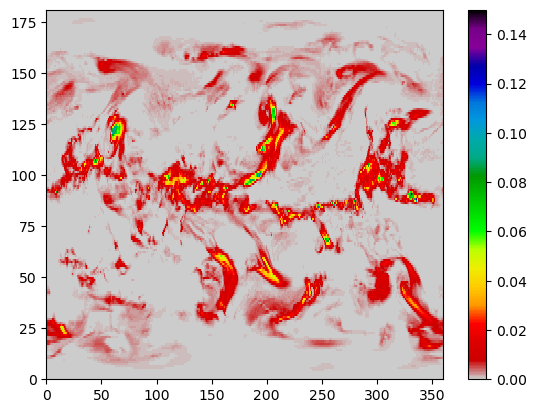

In [11]:
plt.pcolormesh(ERA5_24h[1, ...], vmin=0, vmax=0.15, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

**IMERG has better precip extremes**

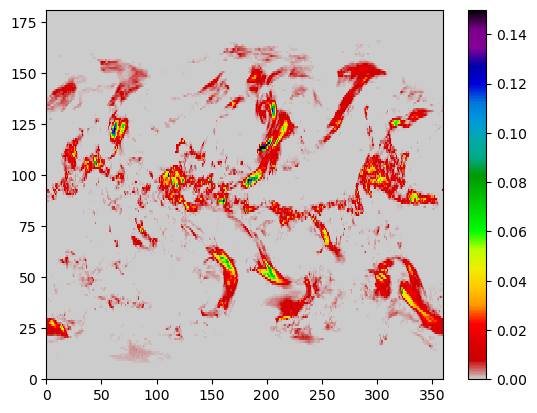

In [12]:
plt.pcolormesh(gpm[0, ...], vmin=0, vmax=0.15, cmap=plt.cm.nipy_spectral_r)
plt.colorbar()

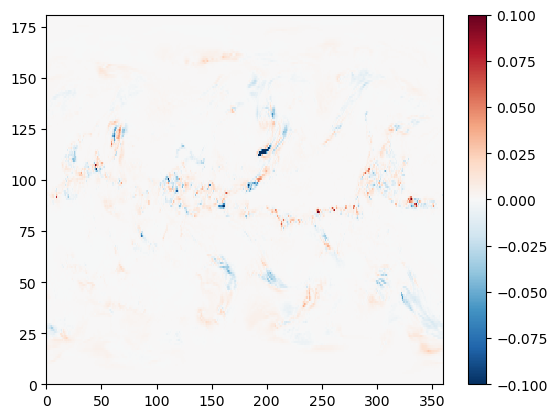

In [13]:
plt.pcolormesh(ERA5_24h[1, ...]-gpm[0, ...], vmin=-0.1, vmax=0.1, cmap=plt.cm.RdBu_r)
plt.colorbar()